In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.utils import plotting_neuronal_behavioural, prep_data, preprocess_data, plot_latent_timeseries, plot_phase_space
from src.data_loading import DatabaseStimuli
from src.bundlenet import BunDLeNet, train_model
import tensorflow as tf

2024-03-26 13:17:55.161271: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-26 13:17:55.196602: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-26 13:17:55.197248: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 13:17:55.756742: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [9]:
import os
os.chdir('../..')
os.getcwd()

'/home/akshey/Desktop/PhD/Code_repositories/BunDLe-Net'

## Load Data (excluding behavioural neurons)

In [12]:
import os
os.getcwd()

'/home/akshey/Desktop/PhD/Code_repositories/BunDLe-Net'

In [209]:
worm_num = 3
b_neurons = [
    'AVAR',
    'AVAL',
]
data = DatabaseStimuli(data_set_no=worm_num)
data.exclude_neurons(b_neurons)
X = data.neuron_traces.T
B = data.states

<IPython.core.display.Javascript object>


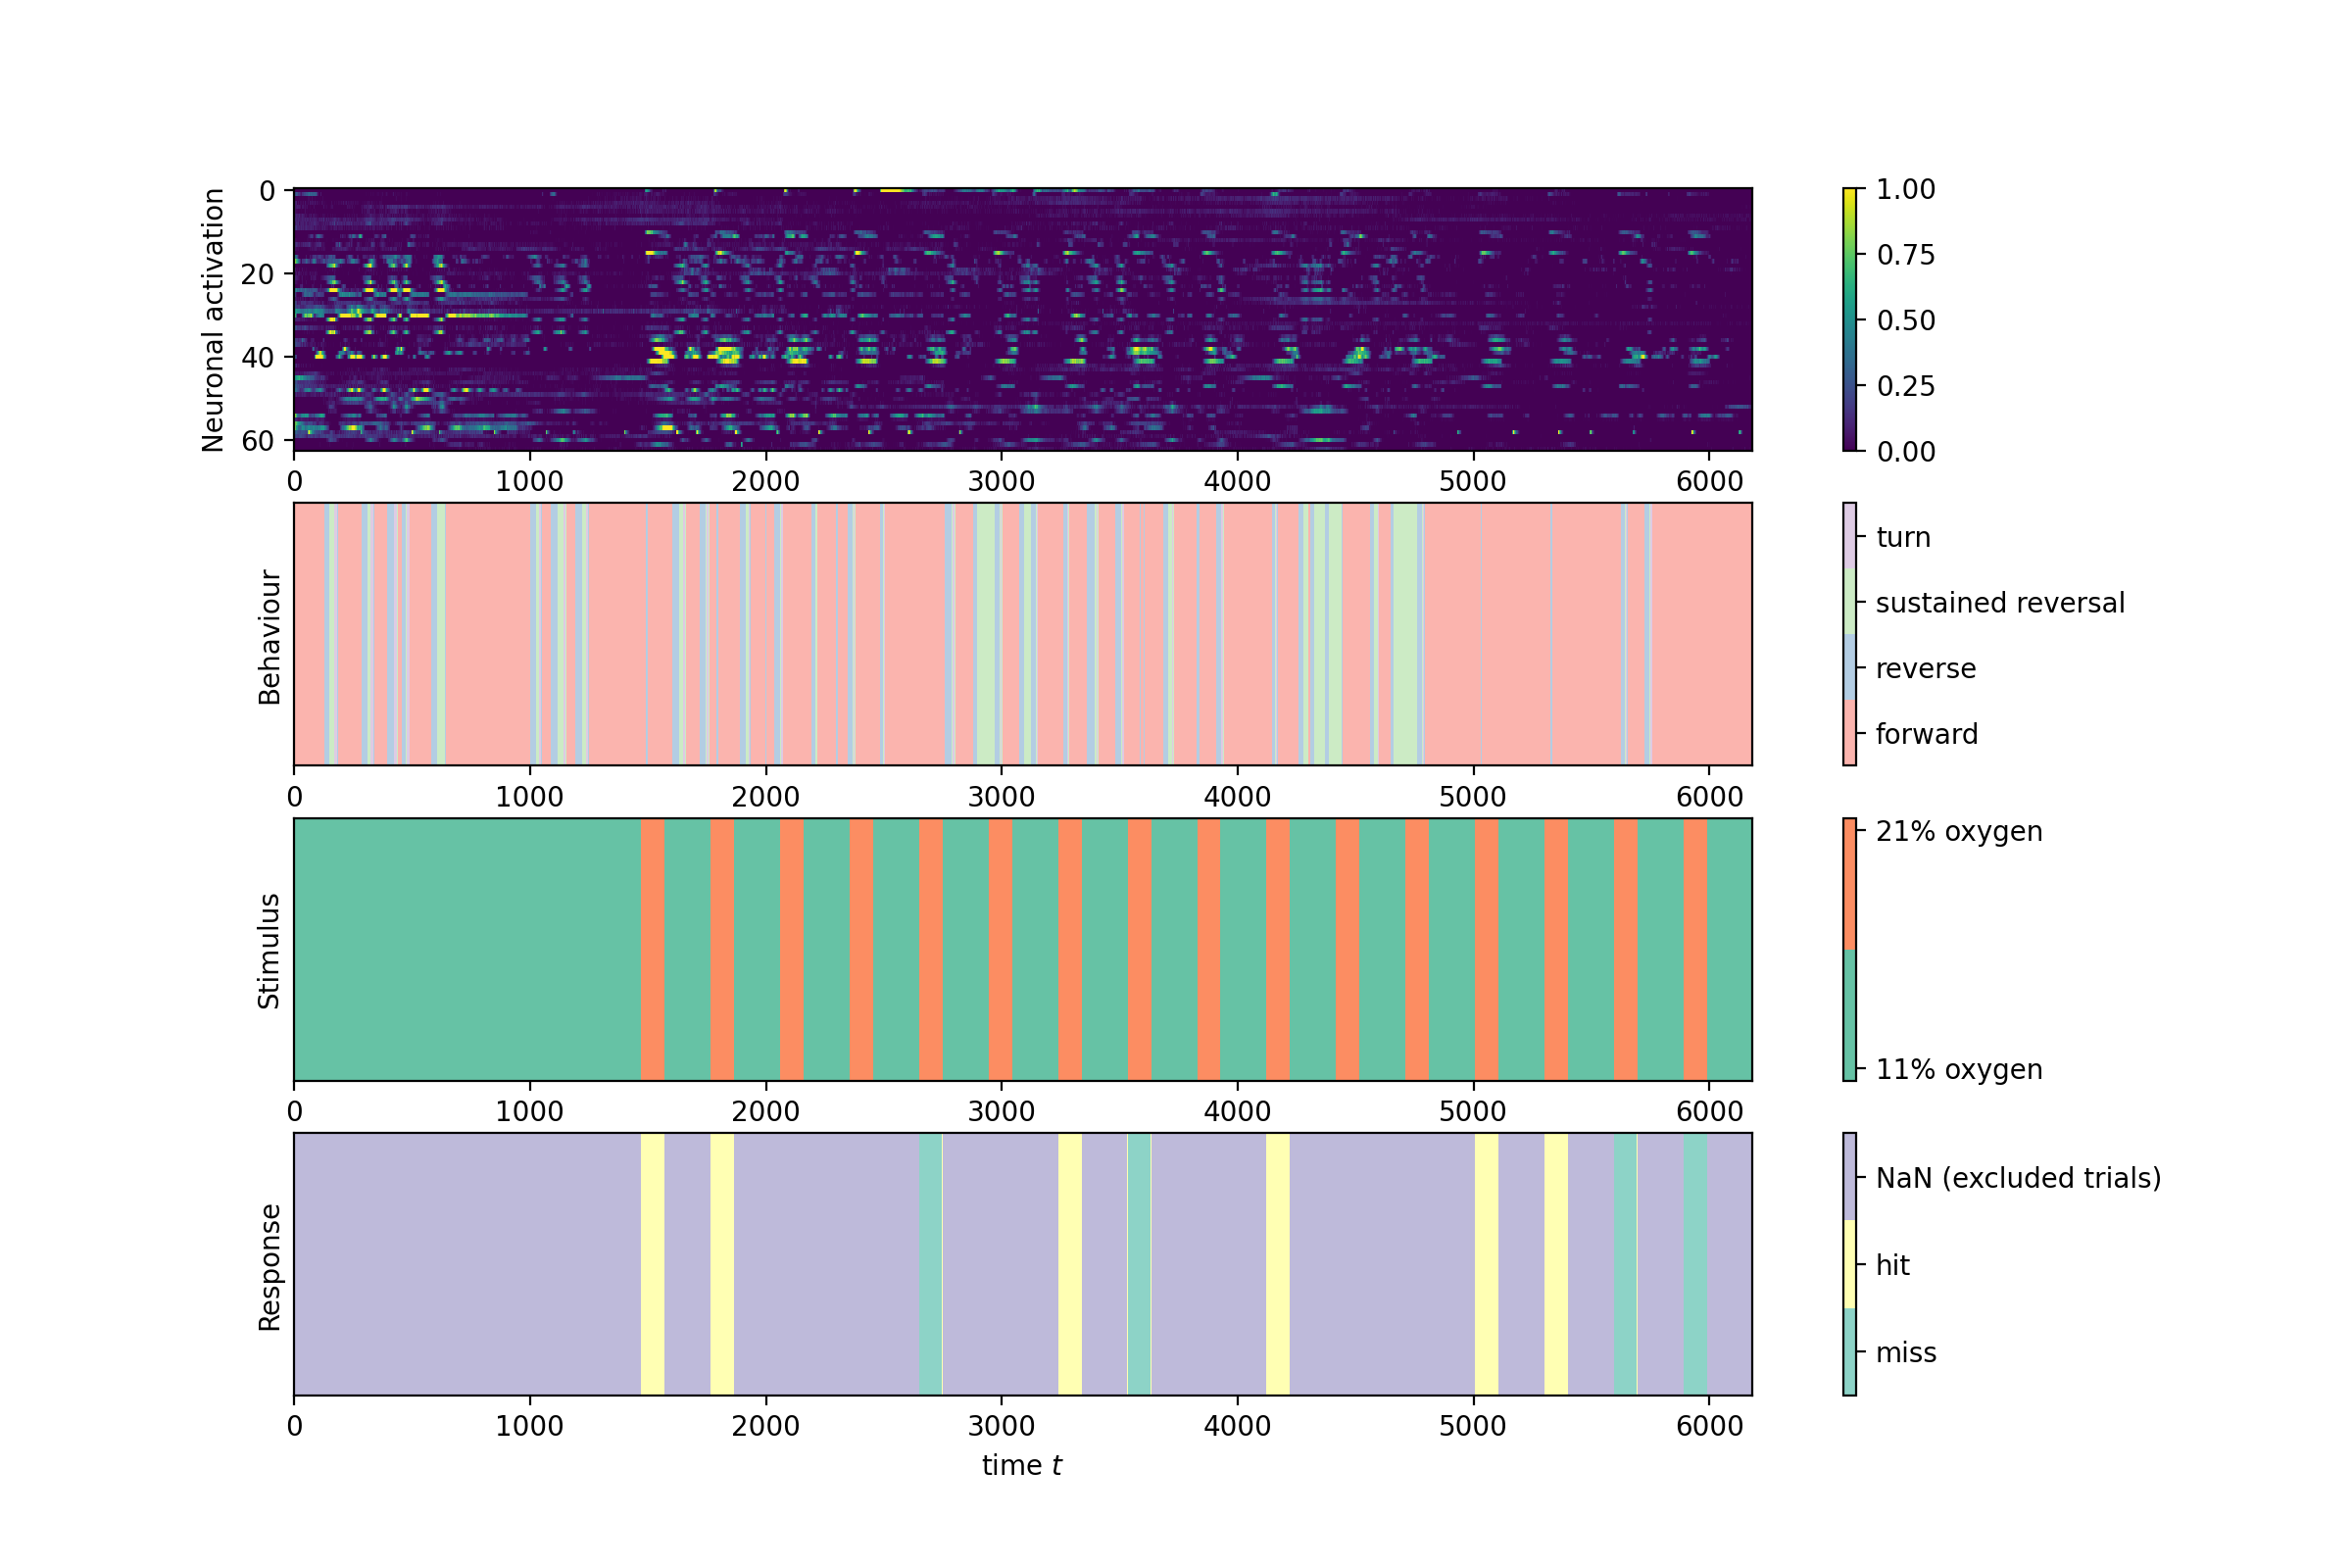

dict_values(['forward', 'reverse', 'sustained reversal', 'turn'])
dict_values(['11% oxygen', '21% oxygen'])
dict_values(['miss', 'hit', 'NaN (excluded trials)'])


In [201]:
def plotting_neuronal_behavioural(X, B, B_names, S, S_names, R, R_names,**kwargs):
    fig, axs = plt.subplots(4,1,figsize=(12,8))
    im0 = axs[0].imshow(X.T,aspect='auto', interpolation='None',**kwargs)
    # tell the colorbar to tick at integers
    cax0 = plt.colorbar(im0)
    axs[0].set_xlabel("time $t$")
    axs[0].set_ylabel("Neuronal activation")
    
    def discrete_plot(ax, B, B_names, y_label, cmap):
        colors = sns.color_palette(cmap, len(B_names))
        cmap = plt.get_cmap(cm.colors.ListedColormap(colors), np.max(B) - np.min(B) + 1)
        im1 = ax.imshow([B], cmap=cmap, vmin=np.min(B) - 0.5, vmax=np.max(B) + 0.5, aspect='auto')
        cax = plt.colorbar(im1, ticks=np.unique(B))
        if B_names:
            print(B_names.values())
            cax.ax.set_yticklabels(list(B_names.values()))
        ax.set_xlabel("time $t$")
        ax.set_ylabel(y_label)
        ax.set_yticks([])
    
    discrete_plot(axs[1], B, B_names, y_label="Behaviour", cmap = 'Pastel1')
    discrete_plot(axs[2], S, S_names, y_label="Stimulus", cmap = 'Set2')
    discrete_plot(axs[3], R, R_names, y_label="Response", cmap = 'Set3')

    plt.show()

plotting_neuronal_behavioural(X, B, data.state_names, data.stimulus, data.stimulus_names, data.response, data.response_names, vmin=0, vmax=1)

## Preprocess data and embed with BunDLe-Net

In [207]:
### Preprocess and prepare data for BundLe Net
#time, X = preprocess_data(X, data.fps)
X_, B_ = prep_data(X, B, win=1)

### Deploy BunDLe Net
model = BunDLeNet(latent_dim=3)
model.build(input_shape=X_.shape)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

loss_array = train_model(
    X_,
    B_,
    model,
    optimizer,
    gamma=0.9, 
    n_epochs=1000,
    pca_init=False,
    best_of_5_init=False
)

Losses 0.003367 0.000005 0.003372: 100%|████████████| 1000/1000 [01:11<00:00, 13.97it/s]


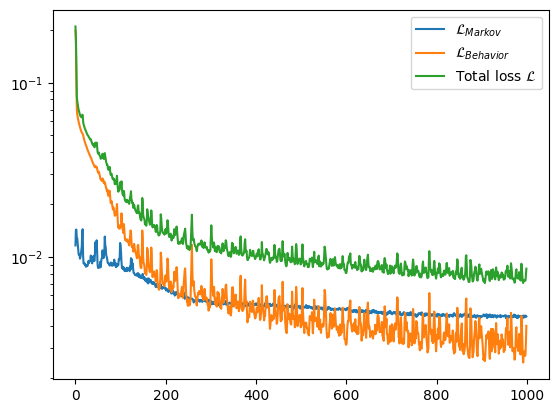

In [193]:
# Training losses vs epochs
plt.figure()
for i, label in  enumerate(["$\mathcal{L}_{{Markov}}$", "$\mathcal{L}_{{Behavior}}$","Total loss $\mathcal{L}$" ]):
	plt.semilogy(loss_array[:,i], label=label)
plt.legend()
plt.show()

## Projecting into latent space

In [194]:
Y0_ = model.tau(X_[:,0]).numpy()

## Visualising embedding

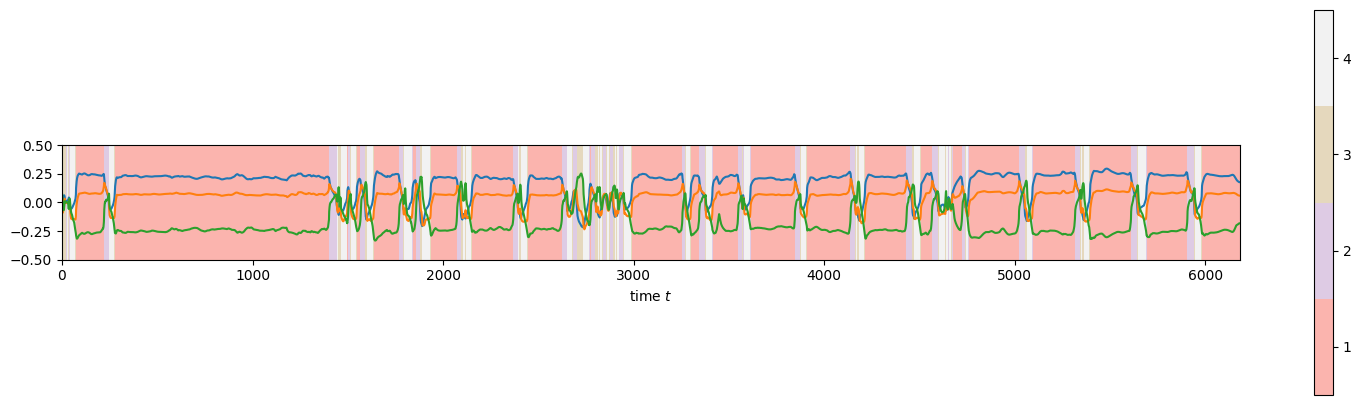

In [195]:
plot_latent_timeseries(Y0_, B_, data.state_names)

<IPython.core.display.Javascript object>


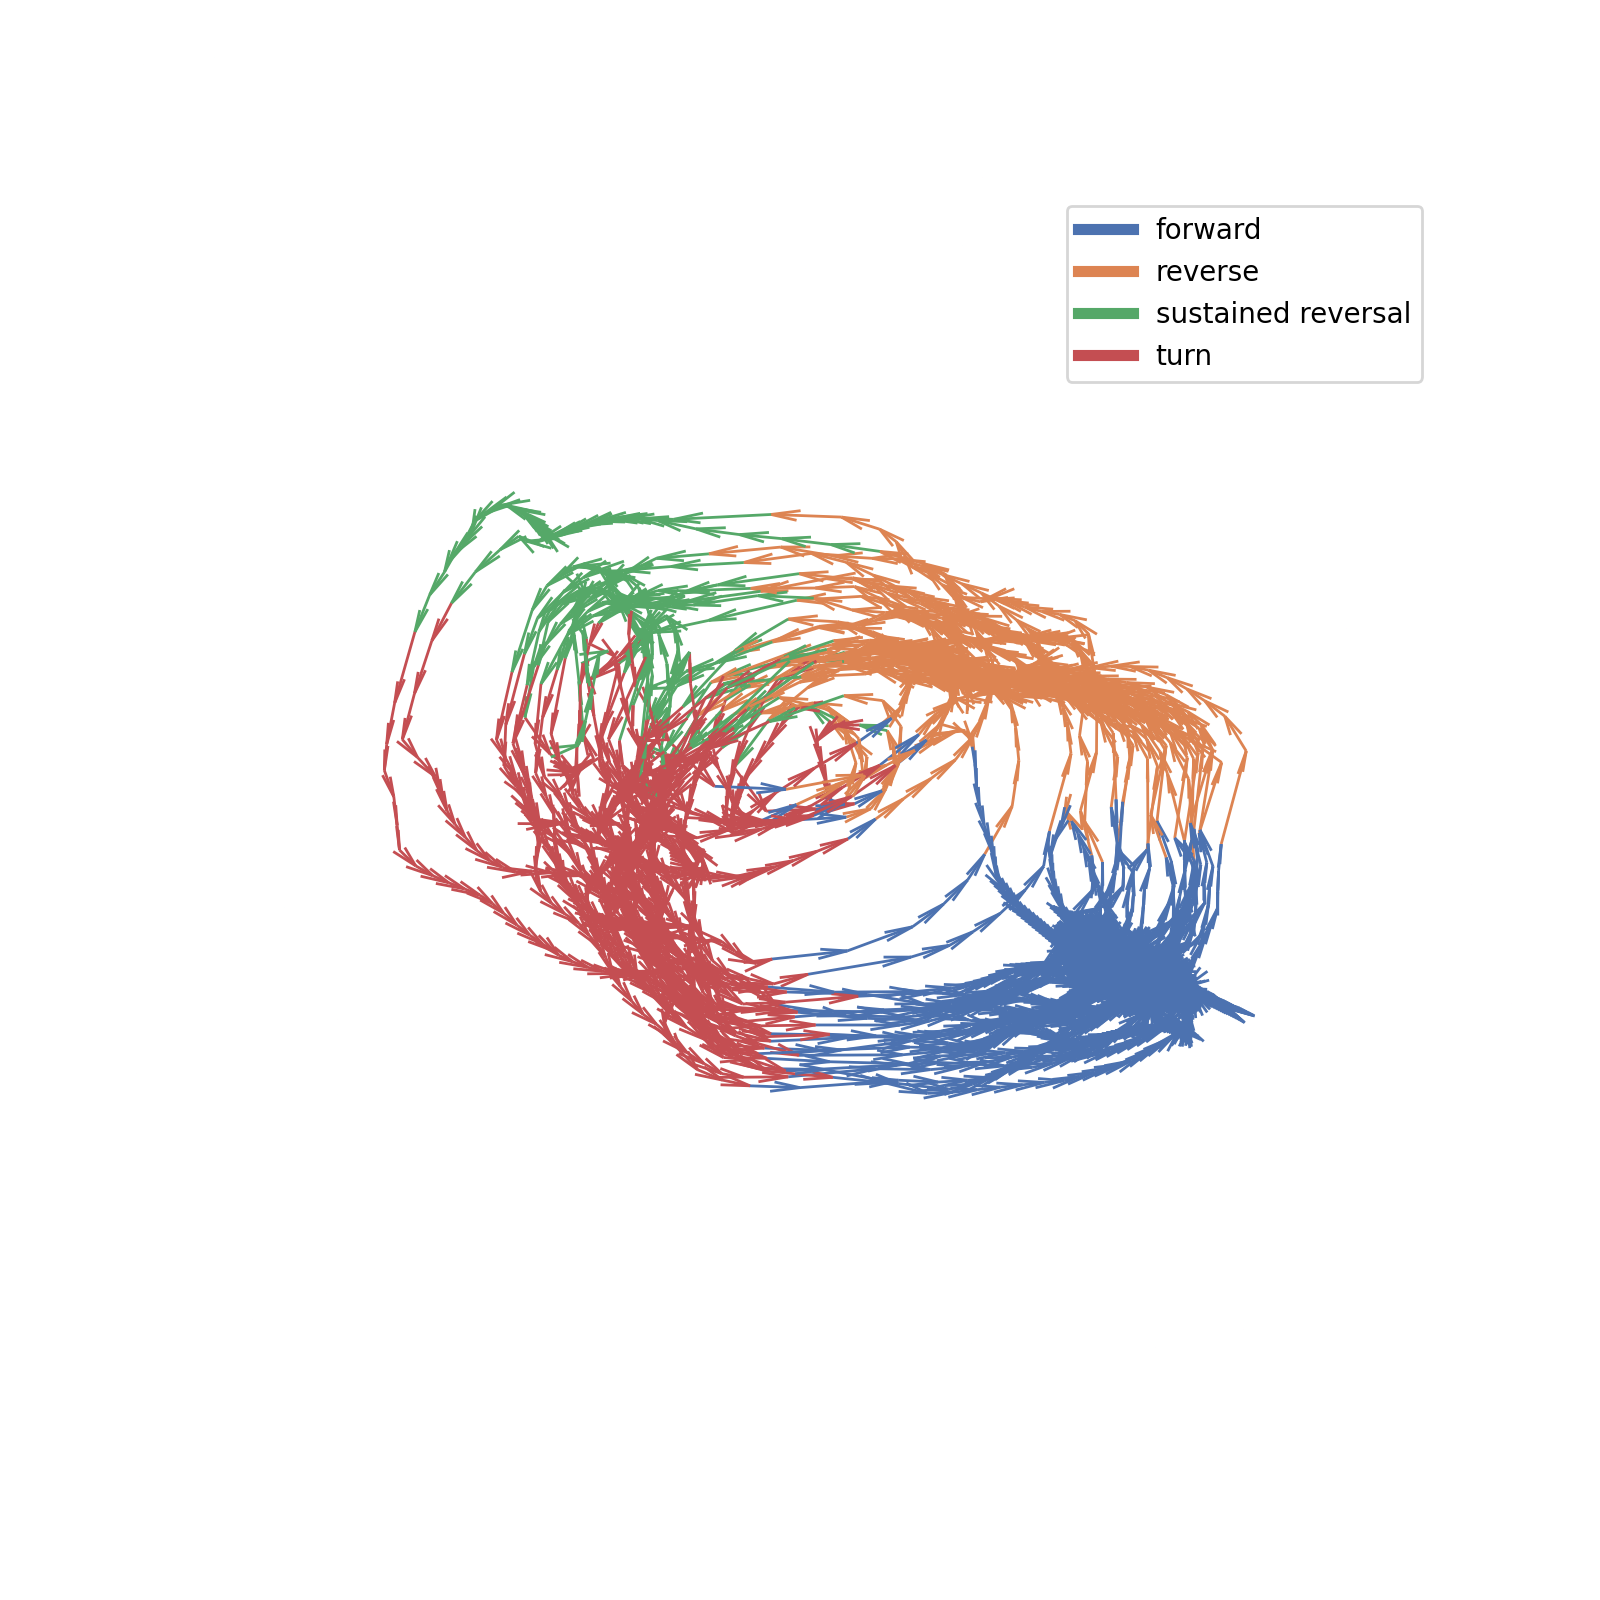

/tmp/ipykernel_3412632/3538093304.py:26: RuntimeWarning: divide by zero encountered in divide
  color=color_dict[B[i]], arrow_length_ratio=0.1/np.linalg.norm(d), linewidths=1, **kwargs)


(<Figure size 800x800 with 1 Axes>, <Axes3D: >)

In [211]:
%matplotlib notebook
plot_phase_space(Y0_, B_, state_names = data.state_names, legend=True)

<IPython.core.display.Javascript object>


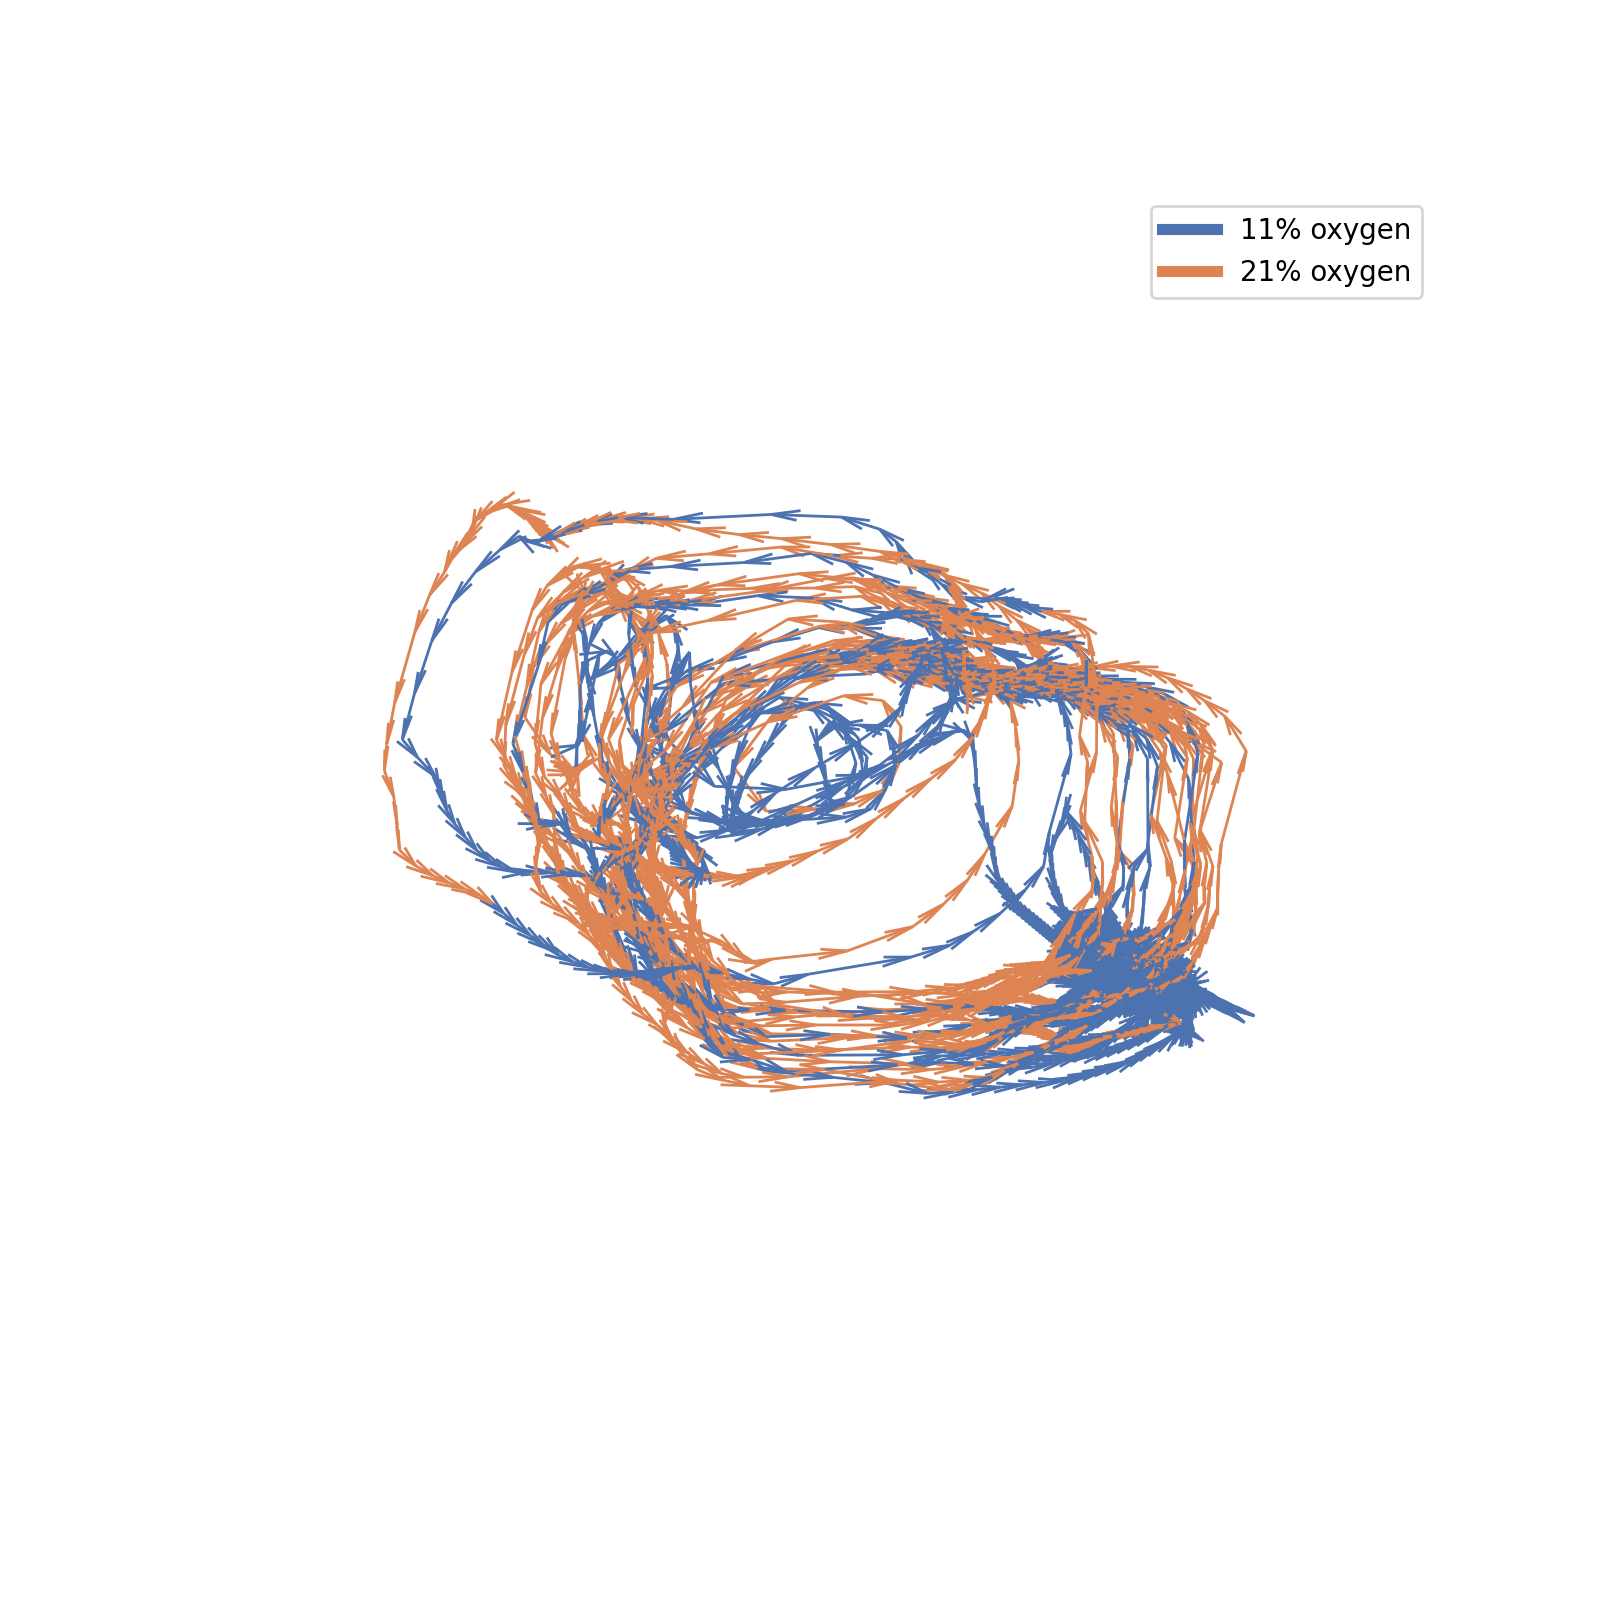

/tmp/ipykernel_3412632/3538093304.py:26: RuntimeWarning: divide by zero encountered in divide
  color=color_dict[B[i]], arrow_length_ratio=0.1/np.linalg.norm(d), linewidths=1, **kwargs)


(<Figure size 800x800 with 1 Axes>, <Axes3D: >)

In [198]:
%matplotlib notebook
plot_phase_space(Y0_, data.stimulus, state_names = data.stimulus_names, legend=True)

<IPython.core.display.Javascript object>


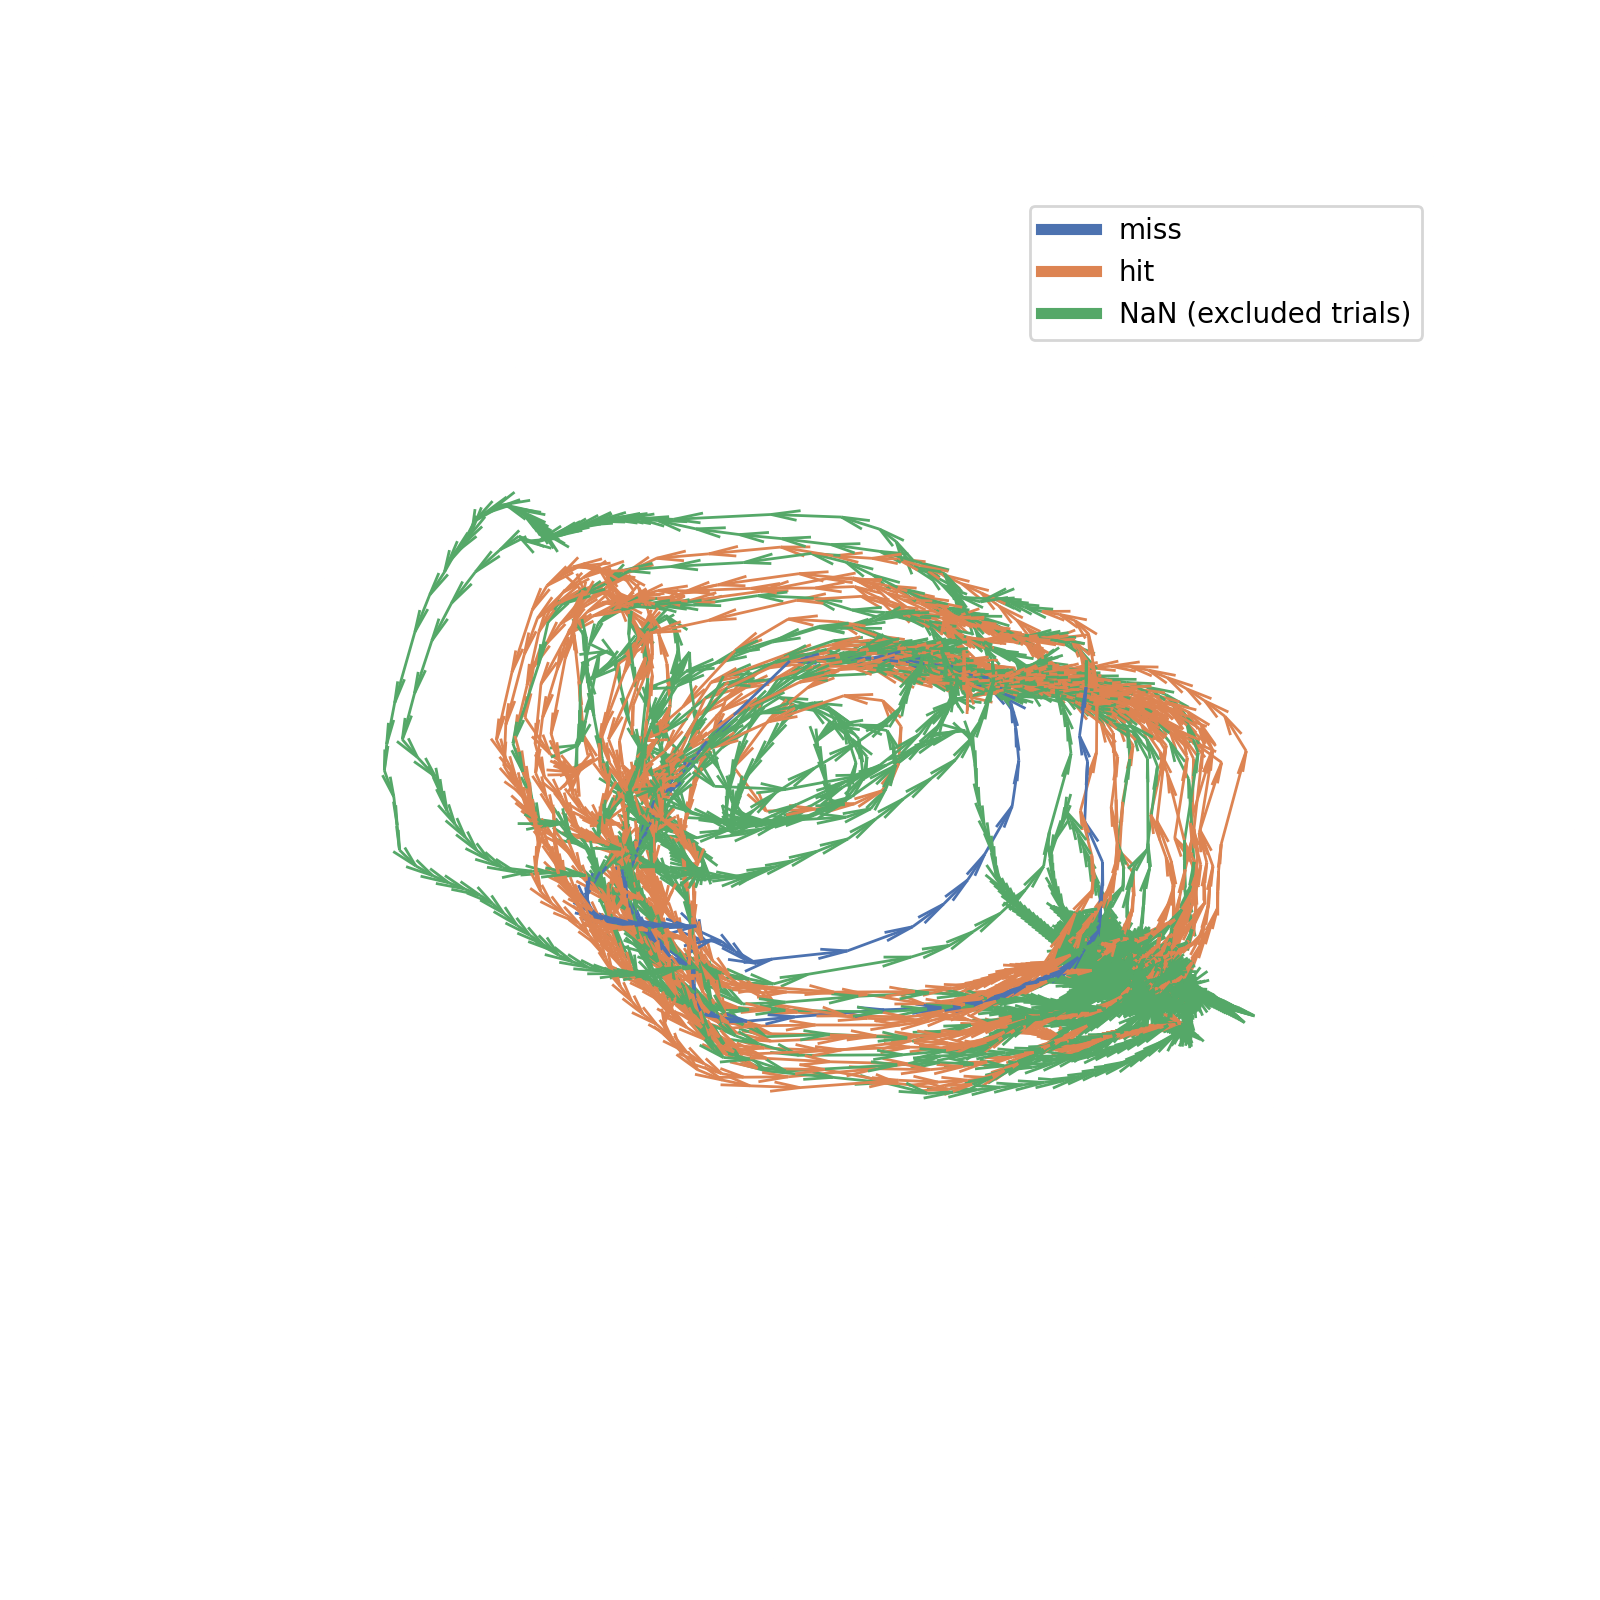

/tmp/ipykernel_3412632/3538093304.py:26: RuntimeWarning: divide by zero encountered in divide
  color=color_dict[B[i]], arrow_length_ratio=0.1/np.linalg.norm(d), linewidths=1, **kwargs)


(<Figure size 800x800 with 1 Axes>, <Axes3D: >)

In [199]:
%matplotlib notebook
plot_phase_space(Y0_, data.response, state_names = data.response_names, legend=True)

In [ ]:
### Run to produce rotating 3-D plot
#%matplotlib notebook
# rotating_plot(Y0_, B_,filename='figures/rotation_'+ algorithm + '_worm_'+str(worm_num) +'.gif', state_names=state_names, legend=False)

### Performing PCA on the latent dimension (to check if there are redundant or correlated components)


In [ ]:
%matplotlib inline
pca = PCA()
Y_pca = pca.fit_transform(Y0_)
plot_latent_timeseries(Y_pca, B_, state_names)


### Recurrence plot analysis of BunDLeNet's embedding

In [ ]:
pd_Y = np.linalg.norm(Y0_[:, np.newaxis] - Y0_, axis=-1) < 0.8
plt.matshow(pd_Y, cmap='Greys')
plt.show()